## Building a Hangul classifier

In [2]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Currently using {device}")

Currently using cuda


Check how many hangul characters are in the dataset

In [3]:
files = os.listdir('data')
unique_chars = sorted(list(set([filename.split("_")[0] for filename in files])))
print(unique_chars)
print(len(unique_chars))

['a', 'ae', 'b', 'bb', 'ch', 'd', 'e', 'eo', 'eu', 'g', 'gg', 'h', 'i', 'j', 'k', 'm', 'n', 'ng', 'o', 'p', 'r', 's', 'ss', 't', 'u', 'ya', 'yae', 'ye', 'yo', 'yu']
30


## Data Preparation

### Loading the dataset  

Here we read all the images in the dataset and package them into a dictionary to be compatible with pytorch.

In [58]:
datas_gray = np.array([cv.imread('data/'+filename, cv.IMREAD_GRAYSCALE).flatten() for filename in sorted(files)]) # image data; sorted in (a -> yu order)
labels = np.array([i for i in range(30) for _ in range(80)]) # class number; there are 80 images per character for 30 total characters

# we assign indexes to each character since the model outputs a number, not characters
# Ex: 0 -> a, 1 -> ae, etc...
classes = dict([(i,char) for i,char in zip([j for j in range(30)], unique_chars)]) 
print(classes)
print(f"Total classes: {len(classes)}")

hangul_unaug = {'data': datas_gray, 'label': labels}

{0: 'a', 1: 'ae', 2: 'b', 3: 'bb', 4: 'ch', 5: 'd', 6: 'e', 7: 'eo', 8: 'eu', 9: 'g', 10: 'gg', 11: 'h', 12: 'i', 13: 'j', 14: 'k', 15: 'm', 16: 'n', 17: 'ng', 18: 'o', 19: 'p', 20: 'r', 21: 's', 22: 'ss', 23: 't', 24: 'u', 25: 'ya', 26: 'yae', 27: 'ye', 28: 'yo', 29: 'yu'}
Total classes: 30


### Data Augmentation  

To introduce variety in the dataset, we will use the images from the dataset and apply transformations. For this model, we apply a random rotation.

In [59]:
transforms = v2.Compose([
                    v2.RandomRotation(degrees=(-90,90), fill=(255,255,255))
                        ])


datas_bgr = np.array([cv.imread('data/'+filename) for filename in sorted(files)]) # image data; sorted in (a -> yu order)
datas_aug = np.array([np.array(transforms(Image.fromarray(data)))[:,:,0].flatten() for data in datas_bgr])

hangul_aug = {'data': datas_aug, 'label': labels}

### Visualizing the dataset

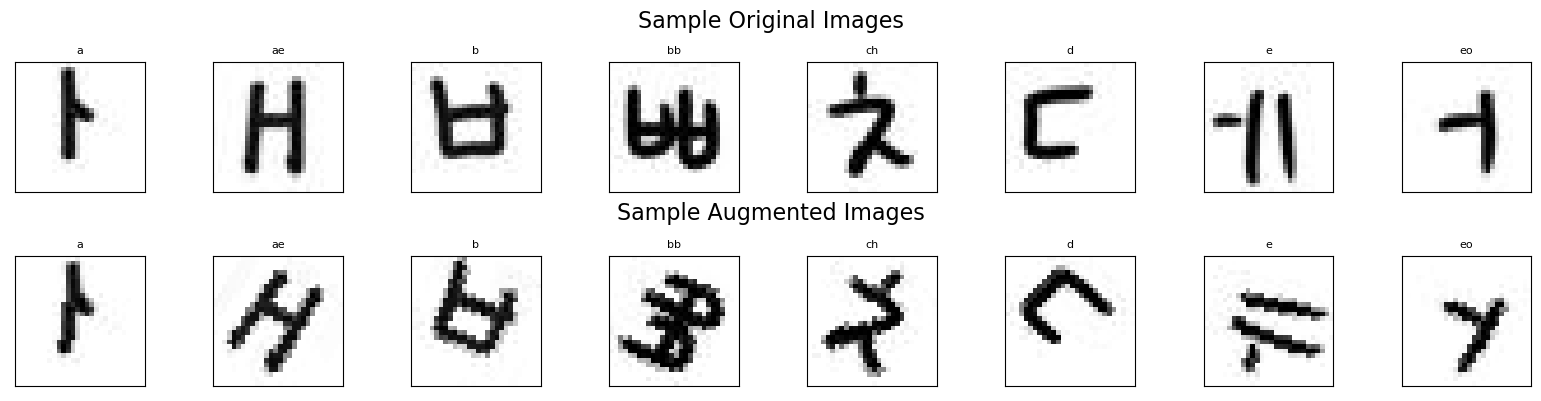

In [60]:
# Create a 2x8 grid of subplots
fig, axs = plt.subplots(2, 8, figsize=(16, 4))

# Plot original images in the first row
for i in range(8):
    axs[0, i].imshow(hangul_unaug['data'][i*80].reshape(28, 28), cmap='gray')
    axs[0, i].set_title(classes[hangul_unaug['label'][i*80]], fontsize=8)
    axs[0, i].axes.xaxis.set_visible(False)
    axs[0, i].axes.yaxis.set_visible(False)

# Plot augmented images in the second row
for i in range(8):
    axs[1, i].imshow(hangul_aug['data'][i*80].reshape(28, 28), cmap='gray')
    axs[1, i].set_title(classes[hangul_aug['label'][i*80]], fontsize=8)
    axs[1, i].axes.xaxis.set_visible(False)
    axs[1, i].axes.yaxis.set_visible(False)

# Add titles for each row of subplots
fig.text(0.5, 0.98, "Sample Original Images", ha='center', fontsize=16, va='top')
fig.text(0.5, 0.5, "Sample Augmented Images", ha='center', fontsize=16, va='top')

plt.tight_layout()
plt.subplots_adjust(top=0.85, hspace=0.5)


Combine the regular and augmented datas into one

In [39]:
hangul = {"data": np.concatenate([hangul_unaug['data'], hangul_aug['data']]), "label": np.concatenate([hangul_unaug['label'],hangul_aug['label']])}

### Split the dataset into training/testing set  

We will compare the model's performance when trained only with unaugmented data vs. both unaugmented + augmented data.

In [63]:
X_train_unaug, X_test_unaug, y_train_unaug, y_test_unaug = train_test_split(hangul_unaug['data'],
                                                    hangul_unaug['label'],
                                                    test_size=0.3,
                                                    random_state=42)
X_train_unaug = torch.from_numpy(X_train_unaug.astype(np.float32)).to(device)
y_train_unaug = torch.from_numpy(y_train_unaug).to(device)
X_test_unaug = torch.from_numpy(X_test_unaug.astype(np.float32)).to(device)
y_test_unaug = torch.from_numpy(y_test_unaug).to(device)


X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(hangul_aug['data'],
                                                    hangul_aug['label'],
                                                    test_size=0.3,
                                                    random_state=42)
X_train_aug = torch.from_numpy(X_train_aug.astype(np.float32)).to(device)
y_train_aug = torch.from_numpy(y_train_aug).to(device)
X_test_aug = torch.from_numpy(X_test_aug.astype(np.float32)).to(device)
y_test_aug = torch.from_numpy(y_test_aug).to(device)

## Implementing a MLP solution

In [64]:
# Define MLP object

class Hangul_MLP(nn.Module):
    """
    A model that implements a logistic regression classifier. 
    """
    def __init__(self, input_size, num_classes):
        """
        Constructor for MLP object

        Args:
            input_size (int): size of input tensor
            num_classes (int): number of classes the model can predict
        """
        super(Hangul_MLP, self).__init__()
        # initialize the model weights

        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, (input_size + num_classes) // 2),
            nn.Sigmoid(),
            nn.Linear((input_size + num_classes) // 2, num_classes),
            nn.Sigmoid()
        )
        print(self.linear_stack)

    def forward(self, x):
        """
        Forward pass of the model

        Args:
            x (tensor): Input to the model
        
        Returns:
            out (tensor): Output of the model

        """
        out = self.linear_stack(x)
        out = F.softmax(out, dim=1)
        return out


### MLP without batch training

In [69]:
def run_model(X_train, y_train, X_test, y_test, n_epochs, lr):
    print(f"Using {device}")
    print("-------------Training model with following architecture---------------")
    # Image size is 28x28, resulting in 784 inputs; 
    model = Hangul_MLP(input_size = 784, num_classes = 30).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses = np.zeros((n_epochs,))
    test_losses = np.zeros((n_epochs,))
    accuracies = np.zeros((n_epochs,))

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        train_losses[epoch] = loss.item()

        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses[epoch] = test_loss.item()
            accuracies[epoch] = (torch.sum(test_outputs.argmax(dim=1) == y_test) / y_test.shape[0]).item()
        loss.backward()
        optimizer.step()
    return train_losses, test_losses, accuracies

In [66]:
train_losses_unaug, test_losses_unaug, accuracies_unaug = run_model(X_train_unaug, y_train_unaug, X_test_unaug, y_test_unaug, 4000, 0.6)
train_losses_aug, test_losses_aug, accuracies_aug = run_model(X_train_aug, y_train_aug, X_test_aug, y_test_aug, 4000, 0.6)

Using cuda
-------------Training model with following architecture---------------
Sequential(
  (0): Linear(in_features=784, out_features=407, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=407, out_features=30, bias=True)
  (3): Sigmoid()
)
Using cuda
-------------Training model with following architecture---------------
Sequential(
  (0): Linear(in_features=784, out_features=407, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=407, out_features=30, bias=True)
  (3): Sigmoid()
)


### Results

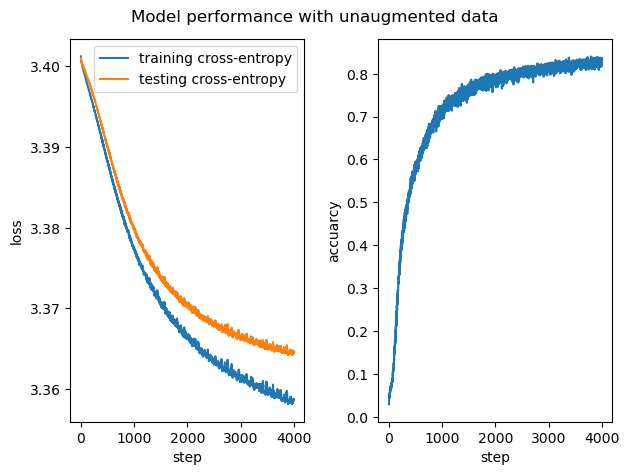

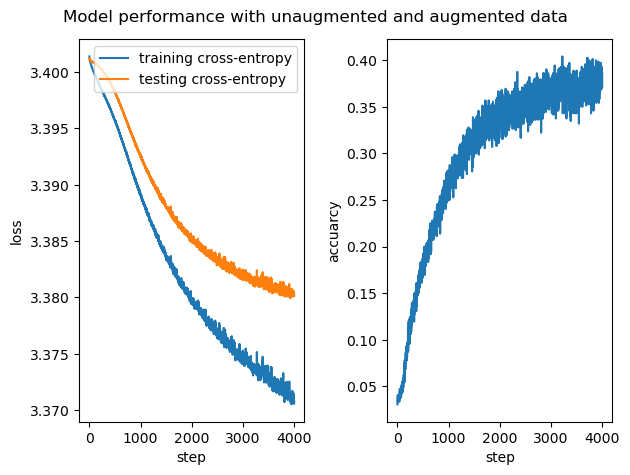

In [74]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(range(len(train_losses_unaug)), train_losses_unaug, label='training cross-entropy')
plt.plot(range(len(test_losses_unaug)), test_losses_unaug, label='testing cross-entropy')
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(accuracies_unaug)), accuracies_unaug)
plt.xlabel('step')
plt.ylabel('accuarcy')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Model performance with unaugmented data")
plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.plot(range(len(train_losses_aug)), train_losses_aug, label='training cross-entropy')
plt.plot(range(len(test_losses_aug)), test_losses_aug, label='testing cross-entropy')
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(accuracies_aug)), accuracies_aug)
plt.xlabel('step')
plt.ylabel('accuarcy')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Model performance with unaugmented and augmented data")
plt.show()

Talk about results here

### MLP with batch training

In [76]:
trainset = torch.utils.data.TensorDataset(X_train_unaug, y_train_unaug)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=80,
                                          generator=torch.Generator(device='cpu'),
                                          shuffle=True)

Sequential(
  (0): Linear(in_features=784, out_features=407, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=407, out_features=30, bias=True)
  (3): Sigmoid()
)


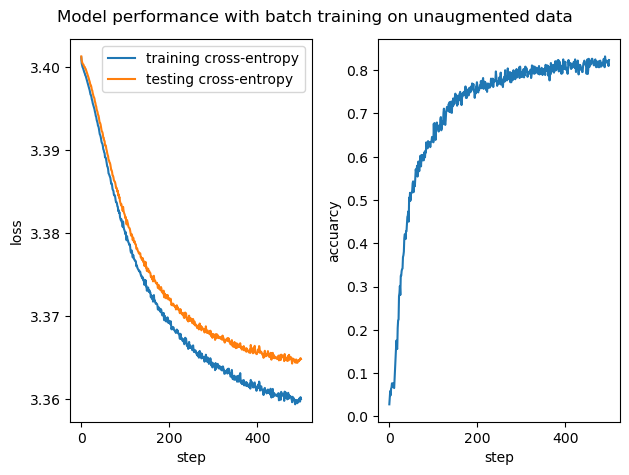

In [77]:
model = Hangul_MLP(input_size = 784, num_classes = 30).to(device)

n_epochs = 500
learning_rate = 0.3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_losses = np.zeros((n_epochs,))
test_losses = np.zeros((n_epochs,))
accuracies = np.zeros((n_epochs,))

for epoch in range(n_epochs):

    with torch.no_grad():
        test_outputs = model(X_test_unaug)
        test_loss = criterion(test_outputs, y_test_unaug)
        test_losses[epoch] = test_loss.item()
        accuracies[epoch] = (torch.sum(test_outputs.argmax(dim=1) == y_test_unaug) / y_test_unaug.shape[0]).item()

        outputs = model(X_train_unaug)
        loss = criterion(outputs, y_train_unaug)
        train_losses[epoch] = loss.item()


    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

plt.figure()
plt.subplot(1,2,1)
plt.plot(range(n_epochs), train_losses, label='training cross-entropy')
plt.plot(range(n_epochs), test_losses, label='testing cross-entropy')
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(n_epochs), accuracies)
plt.xlabel('step')
plt.ylabel('accuarcy')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Model performance with batch training on unaugmented data")
plt.show()

Talk about results here

## Convolutional Neural Network (CNN)

While an MLP can perform image classification, it typically requires the image data to be flattened, which results in the loss of spatial information. Consequently, MLPs generally perform worse on image data compared to CNNs, as they cannot effectively capture spatial features.

CNNs, however, excel at image classification because they preserve the spatial structure of images through convolutional layers. These layers also reduce the number of parameters by sharing weights, enhancing the model's ability to learn intricate patterns. As a result, CNNs tend to achieve higher accuracy and efficiency in image classification tasks, especially when dealing with large-scale datasets and complex visual patterns.

To explore these differences further, we will recreate the LeNet-5 architecture, a CNN structure proposed by LeCun et al. We will assess whether LeNet-5 can outperform the MLP shown above.  

The LeNet-5 Architecture is shown below:  
</br>
<img src="LeNet.png" width="400">  
</br>
By Cmglee - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=104937230

In [ ]:
# Define LeNet object

class LeNet(nn.Module):
    """
    A model that implements a logistic regression classifier. 
    """
    def __init__(self, num_classes):
        """
        Constructor for LeNet object

        Args:
            input_size (int): size of input tensor
            num_classes (int): number of classes the model can predict
        """
        super(LeNet, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            nn.Sigmoid(),

            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=10),
            nn.Sigmoid(),

            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),

            nn.Linear(in_features= 400, out_features=120),
            nn.Sigmoid(),

            nn.Linear(in_features=120, out_features=84),
            nn.Sigmoid(),

            nn.Linear(in_features=84, out_features=num_classes)
        )
        print(self.layers)

    def forward(self, x):
        """
        Forward pass of the model

        Args:
            x (tensor): Input to the model
        
        Returns:
            out (tensor): Output of the model

        """
        out = self.layers(x)
        # out = F.softmax(out, dim=1)
        return out
